In [1]:
#https://docs.zama.ai/concrete-ml/stable/user/advanced_examples/LinearRegression.html

In [2]:
import time
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

# Let’s define our Quantized Linear Regression module that quantizes a sklearn linear regression¶

In [4]:
# pylint: disable=unbalanced-tuple-unpacking
X, y = make_regression(
    n_samples=200, n_features=1, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
# pylint: enable=unbalanced-tuple-unpacking

# Split it into train/test and sort the sets for nicer visualization
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

sidx = np.argsort(np.squeeze(x_train))
x_train = x_train[sidx, :]
y_train = y_train[sidx]

sidx = np.argsort(np.squeeze(x_test))
x_test = x_test[sidx, :]
y_test = y_test[sidx]

# Train a linear regression on the training set and visualize predictions on the test set

In [5]:
linreg = SklearnLinearRegression()
tic = time.perf_counter()
linreg.fit(x_train, y_train)
toc = time.perf_counter()
print(f"Classic sklearn fitting {toc - tic:0.4f} seconds")

Classic sklearn fitting 0.0011 seconds


In [6]:
tic = time.perf_counter()
y_pred = linreg.predict(x_test)
toc = time.perf_counter()
time_sklearn_model_predict = toc - tic
print(f"Classic sklearn model prediction {time_sklearn_model_predict:0.4f} seconds")

Classic sklearn model prediction 0.0002 seconds


# Visualize the regression line and the data set

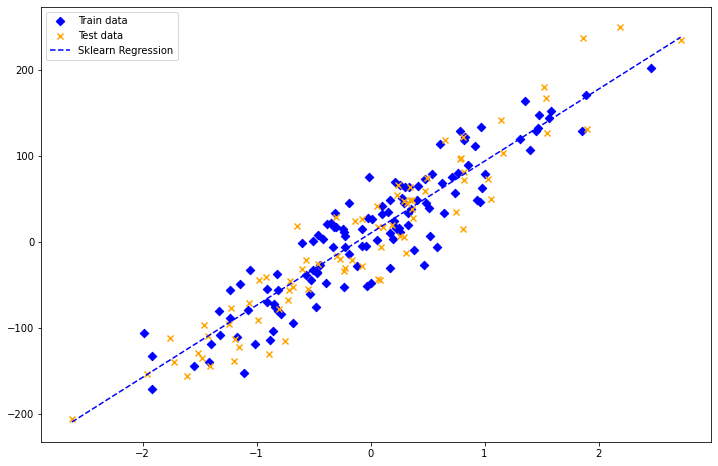

In [7]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(x_train, y_train, c="blue", marker="D", label="Train data")
ax.scatter(x_test, y_test, c="orange", marker="x", label="Test data")
ax.plot(x_test, y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)


# Calibrate the model for quantization using both training and test data

In [8]:
q_linreg = ConcreteLinearRegression(n_bits={"inputs": 6, "weights": 1})
tic = time.perf_counter()
q_linreg.fit(x_train, y_train)
toc = time.perf_counter()
print(f"FHE sklearn model fit {toc - tic:0.4f} seconds")

FHE sklearn model fit 0.0939 seconds


# Now, we can compile our model to FHE, taking as the possible input set all of our dataset

In [9]:
tic = time.perf_counter()
q_linreg.compile(X)
toc = time.perf_counter()
print(f"FHE sklearn model compile {toc - tic:0.4f} seconds")

FHE sklearn model compile 1.1973 seconds


# Time to make some predictions, first in the clear¶

In [10]:
# Now that the model is quantized, predict on the test set
tic = time.perf_counter()
y_pred_q = q_linreg.predict(x_test)
toc = time.perf_counter()
time_q_sklearn_model_predict = toc - tic

print(f"FHE sklearn model clear predict {time_q_sklearn_model_predict:0.4f} seconds")

FHE sklearn model clear predict 0.0005 seconds


# Now let’s predict using the quantized FHE classifier

In [11]:
# Now predict using the FHE-quantized model on the testing set
tic = time.perf_counter()
y_test_pred_fhe = q_linreg.predict(x_test, execute_in_fhe=True)
toc = time.perf_counter()
time_q_fhe_sklearn_model_predict_1 = toc - tic

print(f"FHE sklearn model predict {time_q_fhe_sklearn_model_predict_1/60:0.4f} minutes")

IOStream.flush timed out


FHE sklearn model predict 22.4888 minutes


In [12]:
# Now predict using the FHE-quantized model on the testing set
tic = time.perf_counter()
y_test_pred_fhe = q_linreg.predict(x_test, execute_in_fhe=True)
toc = time.perf_counter()
time_q_fhe_sklearn_model_predict_2 = toc - tic

print(f"FHE sklearn model predict {time_q_fhe_sklearn_model_predict_2/60:0.4f} minutes")

FHE sklearn model predict 2.6027 minutes


# Evaluate all versions of the classifier

In [13]:
# Measure the error for the three versions of the classifier
sklearn_r2 = r2_score(y_pred, y_test)
non_homomorphic_test_error = r2_score(y_pred_q, y_test)
homomorphic_test_error = r2_score(y_test_pred_fhe, y_test)

# Measure the error of the FHE quantized model w.r.t the clear quantized model
difference = (
    abs(homomorphic_test_error - non_homomorphic_test_error) * 100 / non_homomorphic_test_error
)


print(f"Sklearn R^2: {sklearn_r2:.4f}")
print(f"Non Homomorphic R^2: {non_homomorphic_test_error:.4f}")
print(f"Homomorphic R^2: {homomorphic_test_error:.4f}")
print(f"Relative Difference Percentage: {difference:.2f}%")


Sklearn R^2: 0.8758
Non Homomorphic R^2: 0.8627
Homomorphic R^2: 0.8627
Relative Difference Percentage: 0.00%


# Plot the results of both the original and FHE versions of the classifier

In [14]:
# Create a new x that covers the entire space of the original x
x_space = np.linspace(x_test.min(), x_test.max(), 100)
x_space = x_space[:, np.newaxis]
y_pred_space_q = q_linreg.predict(x_space)

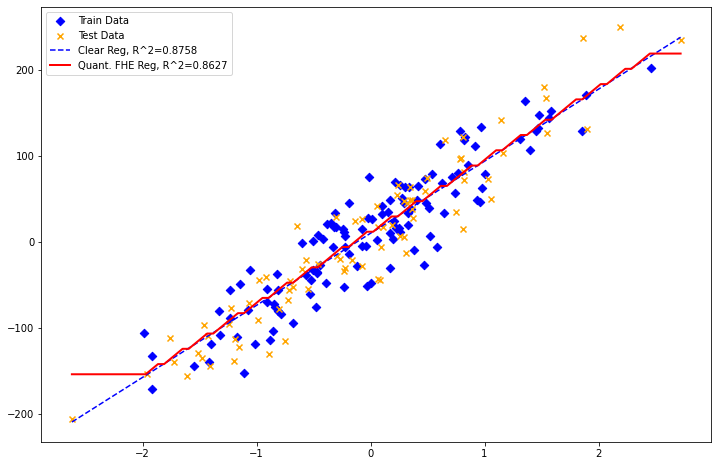

In [15]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
s1 = ax.scatter(x_train, y_train, c="blue", marker="D")
s2 = ax.scatter(x_test, y_test, c="orange", marker="x")
p1 = ax.plot(x_test, y_pred, c="blue", marker=None, linestyle="dashed")
p2 = ax.plot(x_space, y_pred_space_q, c="red", marker=None, linewidth=2)
ax.legend(
    [s1, s2, p1[0], p2[0]],
    [
        "Train Data",
        "Test Data",
        f"Clear Reg, R^2={sklearn_r2:.4f}",
        f"Quant. FHE Reg, R^2={homomorphic_test_error:.4f}",
    ],
)
display(fig)

In [23]:
print(f"Classic sklearn model prediction {time_sklearn_model_predict:0.4f} seconds")
print(f"FHE sklearn model clear predict {time_q_sklearn_model_predict:0.4f} seconds ({time_q_sklearn_model_predict/time_sklearn_model_predict:0.1f} longer than sklearn model")
print(f"FHE sklearn model predict {time_q_fhe_sklearn_model_predict_1/60:0.1f} minutes, {time_q_fhe_sklearn_model_predict_1/x_test.shape[0]:0.1f}s per record ({time_q_fhe_sklearn_model_predict_1/time_sklearn_model_predict:0.1f} longer than sklearn model)")
print(f"FHE sklearn model predict {time_q_fhe_sklearn_model_predict_2/60:0.1f} minutes, {time_q_fhe_sklearn_model_predict_2/x_test.shape[0]:0.1f}s per record ({time_q_fhe_sklearn_model_predict_2/time_sklearn_model_predict:0.1f} longer than sklearn model)")

Classic sklearn model prediction 0.0002 seconds
FHE sklearn model clear predict 0.0005 seconds (2.6 longer than sklearn model
FHE sklearn model predict 22.5 minutes, 16.9s per record (7019099.8 longer than sklearn model)
FHE sklearn model predict 2.6 minutes, 2.0s per record  (812348.4 longer than sklearn model)


80

In [17]:
#Classic sklearn model prediction 0.0009 seconds
#FHE sklearn model clear predict 0.0091 seconds (10.5 longer than sklearn model
#FHE sklearn model predict 3133.2145 seconds (3644382.9 longer than sklearn model